In [1]:
import pandas as pd
import numpy as np
import pandasql as ps
import time

import matplotlib.pyplot as plt

#I know, what I'm doing, sometimes pandas gets all warningish 
#about setting value on a copy of a dataframe, and .loc doesn't help
pd.set_option('chained_assignment',None)

In [2]:
coor = pd.read_csv('coordinates.csv')
pos = pd.read_csv('positions.csv')
deaths = pd.read_csv('deaths.csv')
shots = pd.read_csv('shots.csv')

In [3]:
pos['server_timestamp'] = pd.to_datetime(pos['server_timestamp'])
pos = pos.sort_values(by='server_timestamp').reset_index(drop=True)

deaths['server_timestamp'] = pd.to_datetime(deaths['server_timestamp'])
deaths = deaths.sort_values(by='server_timestamp').reset_index(drop=True)

shots['server_timestamp'] = pd.to_datetime(shots['server_timestamp'])
shots = shots.sort_values(by='server_timestamp').reset_index(drop=True)

In [4]:
# For the sake of easier sorting and understanding, I've renamed the bosses locations.
coor['area'] = coor['area'].replace({'first_boss_fight': '1_boss_fight', \
                                     'second_boss_fight': '2_boss_fight', \
                                     'final_boss_fight': '3_boss_fight'})

Ok, so we have two issues: <br>
1) Players struggle in the third batwing encounter
2) Players struggle in the bunker because they don’t use the fire ammo

The main question actually is "Why?".
What was the list of reasons the players had difficulties with this locations?
The reasons may be of several types.
- misunerstandment of situation (like with the fire ammo, when some players have already forgotten they've got one)
- gap between levels of enemy and player is too big
- desired strategy can't be used due to some unavoidable reasons

### Firstly, let's explore our data a little bit.


#### Coordinates

In [5]:
display(coor)

,x_min,x_max,z_min,z_max,area
0,-320.0,-260.0,275.0,320.0,upper_funicular
1,-260.0,-210.0,250.0,290.0,1_boss_fight
2,260.0,370.0,500.0,600.0,first_submarine_area
3,50.0,100.0,310.0,370.0,humanimal_infested_pool
4,50.0,100.0,200.0,290.0,school
5,-180.0,-70.0,240.0,320.0,club_movie
6,-100.0,-30.0,150.0,220.0,captains_house
7,-140.0,-90.0,0.0,50.0,house_before_sniper
8,-70.0,-20.0,-20.0,50.0,sniper_house
9,-140.0,-90.0,-210.0,-150.0,mall


These are coordinates of nodes of the grid map. 
We are not so interested in "None" and "Final" and we'd better get rid of them.

In [6]:
coor = coor.dropna()

#### Appending area

There are two ways to concat area names to all the tables. <br>
With SQL and with Python. <br>
As long this is a test assignment (and especially python assignment) I'll show both.

In [7]:
%%time
#SQL is faster, but I feel a bit strange, using SQL hacks in Jupyter notebook

sqlcode = '''
select pos.*, coor.area
from pos
inner join coor 
    on (pos.pos_z between coor.z_min and coor.z_max) 
    and (pos.pos_x between coor.x_min and coor.x_max) 
'''

pos_1 = ps.sqldf(sqlcode,locals())
display(pos_1[['pos_x', 'pos_z', 'area']].sample(10))

,pos_x,pos_z,area
11007,-413.000000,-124.000000,bandit_outpost
10856,-430.000000,-275.000000,open_area_after_mall
1930,-119.000000,-195.000000,mall
13068,-503.000000,-736.000000,bunker
3805,-346.000000,-126.000000,bandit_outpost
4568,-561.000000,-35.000000,worm_lair
5909,376.947388,621.083618,final_submarine_area
10069,-106.000000,-189.000000,mall
12192,-559.000000,-24.000000,worm_lair
14177,393.464905,473.990723,final_submarine_area


CPU times: user 442 ms, sys: 17.3 ms, total: 460 ms
Wall time: 460 ms


In [8]:
#And Python doesn't have this magic option, as far as I know. 
#I guess there is a way to make it faster, but the easiest way is
#to write a function. It works waaaay longer, but it works
def map_search (x, z, coor):
    for i in range(len(coor)):
        x_min, x_max = coor.iloc[i][['x_min', 'x_max']]
        z_min, z_max = coor.iloc[i][['z_min', 'z_max']]
        if x>=x_min and x<=x_max and z>=z_min and z<=z_max:
            return coor.iloc[i]['area']
    return ''

In [9]:
%%time
pos_2 = pos.copy()
pos_2['area'] = pos_2[['pos_x', 'pos_z']]\
    .apply(lambda x: map_search(x['pos_x'], x['pos_z'], coor), axis=1)

CPU times: user 1min 15s, sys: 262 ms, total: 1min 15s
Wall time: 1min 15s


From this time on I'll be using SQL method as the fastest one.

In [11]:
#Positions
sqlcode = '''
select pos.*, coor.area
from pos
inner join coor 
    on (pos.pos_z between coor.z_min and coor.z_max) 
    and (pos.pos_x between coor.x_min and coor.x_max) 
'''

pos = ps.sqldf(sqlcode,locals())
pos['server_timestamp'] = pd.to_datetime(pos['server_timestamp'])


#Deaths
sqlcode = '''
select deaths.*, coor.area
from deaths
inner join coor 
    on (deaths.pos_z between coor.z_min and coor.z_max) 
    and (deaths.pos_x between coor.x_min and coor.x_max) 
'''

deaths = ps.sqldf(sqlcode,locals())
deaths['server_timestamp'] = pd.to_datetime(deaths['server_timestamp'])

#### Positions

In [12]:
#Positions is a big table, let's first look at the list of columns
print(pos.columns)

Index(['player', 'user_id', 'session_data.user_id', 'id', 'event_type',
       'timestamp', 'server_timestamp', 'session_id', 'protocol_version',
       'session_event_seq_num', 'country_code_iso', 'client_timezone', 'pos_z',
       'pos_x', 'pos_y', 'session_data.game_id', 'session_data.platform_id',
       'session_data.sec', 'session_data.build_id', 'session_data.playtest_id',
       'session_data.playtest_player',
       'session_data.input_device.input_device',
       'session_data.level_state.map_name',
       'session_data.difficulty.difficulty', 'debugevent.timestamp',
       'debugevent.millhost', 'debugevent.flowhost', 'debugevent.inflighttime',
       'debugevent.redeliverd', 'debugevent.sequence', 'debugevent.eventcount',
       'debugevent.timeinbuffer', 'debugevent.batchid', 'date', 'area'],
      dtype='object')


We've made some explorations during the first interview, so I won't repeat them.
We already know, that a player could have several sessions due to bugs and emergency exits from the game, and total time playing is either 7h or 1h 45min. 

Also, there are some 'debugevents'. As I'm not sure what they mean, I'll leave them be for now.

In [13]:
#We could be interested in this column

display(pos.groupby('player')['session_data.input_device.input_device'].value_counts())

player  session_data.input_device.input_device
DSHQ01  gamepad                                   1469
        keyboard                                    36
DSHQ02  keyboard                                  1717
        gamepad                                     14
DSHQ03  gamepad                                   1219
        keyboard                                     1
DSHQ04  keyboard                                  1516
DSHQ05  keyboard                                   398
DSHQ06  gamepad                                    424
        keyboard                                     2
DSHQ07  gamepad                                    393
        keyboard                                     2
DSHQ08  keyboard                                  1574
DSHQ09  gamepad                                   1359
        keyboard                                     9
DSHQ10  keyboard                                  1484
DSHQ11  keyboard                                  1140
DSHQ12  gamepad   

In [14]:
#Oh, yes, that's the thing to be checked

pos['session_data.difficulty.difficulty'].value_counts()

normal    14270
Name: session_data.difficulty.difficulty, dtype: int64

As a conclusion, table Positions for us is mainly a source of knowledge when and where was a player.

And, how frequently does the position update?

In [15]:
def mean_delta(x):
    return  (x-x.shift(1)).mean().seconds

def std_delta(x):
    return  (x-x.shift(1)).std().seconds

pos.sort_values(by='server_timestamp').groupby('player')\
    .agg({'server_timestamp': [mean_delta, std_delta]})

server_timestamp          
             mean_delta std_delta
player                           
DSHQ01               16       107
DSHQ02               16        99
DSHQ03               20       131
DSHQ04               16       114
DSHQ05               14        20
DSHQ06               14        18
DSHQ07               15        20
DSHQ08               16       107
DSHQ09               16       135
DSHQ10               17       130
DSHQ11               18       152
DSHQ12               16       124

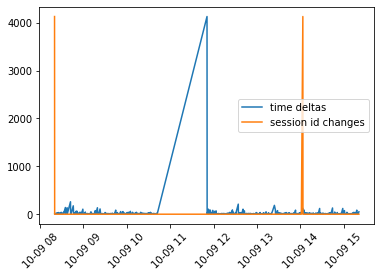

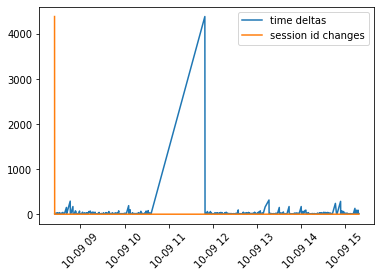

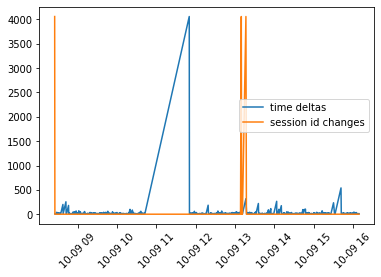

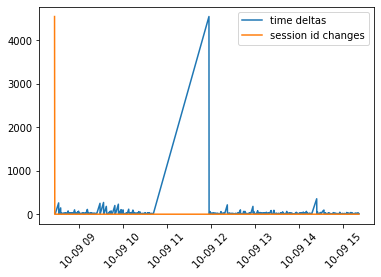

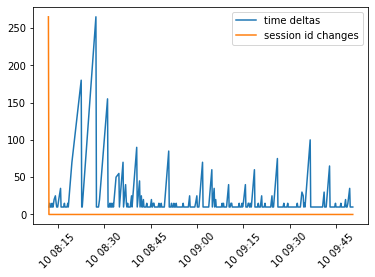

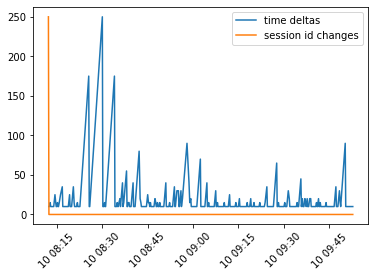

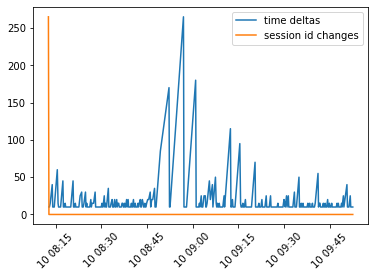

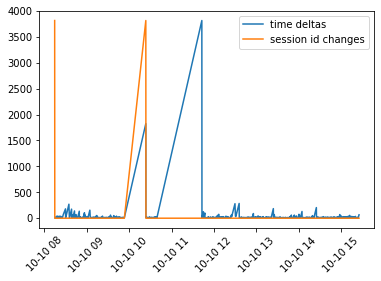

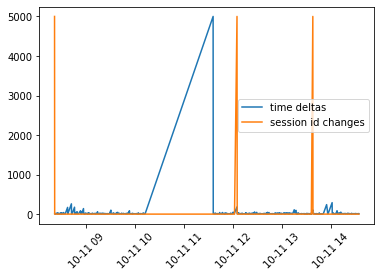

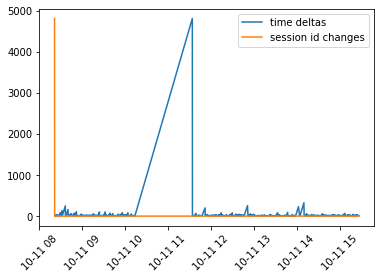

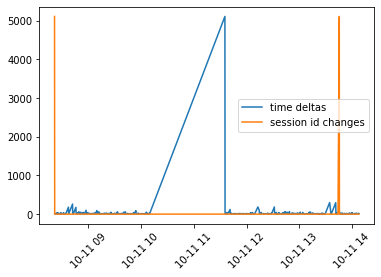

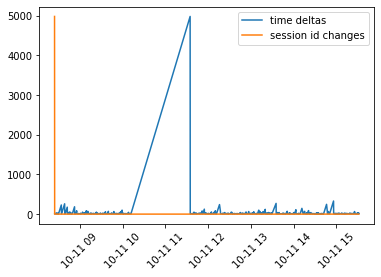

In [16]:
for p in list(pos['player'].unique()):
    t = pos[pos['player']==p][['server_timestamp']]
    t['delta'] = (t['server_timestamp']-t['server_timestamp'].shift(1)).dt.seconds
    plt.plot(t['server_timestamp'], t['delta'], label='time deltas')
    
    #and let's check if chenging session id correlates with deltas
    s = pos[pos['player']==p]['session_id'] != pos[pos['player']==p]['session_id'].shift(1)
    plt.plot(t['server_timestamp'], s*t['delta'].max(), label='session id changes')
    
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

There is a major gap from 10 to 12 and it happaned at the same time for everyone (except players who left early). While the minor gaps at the beginning of timeseries can be cutscenes, this one is most definetly some lunch brake or something like that. And it's not connected to the change of session. So we'll need to deal with it if we want to measure time spent in location.

There could be some other brakes that we did't notice. So it's better to find a way to locate such outliers. 

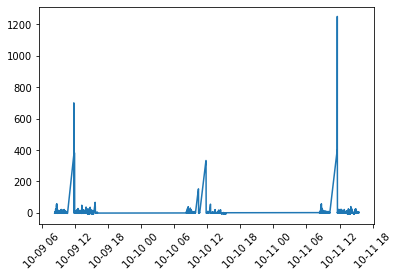

In [17]:
sum_list = []
for p in list(pos['player'].unique()):
    t = pos[pos['player']==p][['server_timestamp']]
    delta = (t['server_timestamp']-t['server_timestamp'].shift(1)).dt.seconds
    delta = delta.to_frame()
    delta.index = t['server_timestamp']
    #For each player I calculate deltas between records 
    #and then subtract the mean delta without outliers
    delta_cut = delta[delta<delta.mean()+3*delta.std()]
    sum_list.append(delta-delta_cut.mean())
    
#And then, combining all of them together, 
#I calculate the rolling mean of these deltas for every n_players values
#to see at what time they all had deltas sugnificantly bigger than usual
sum_df = pd.concat(sum_list).dropna()  
sum_df = sum_df.sort_index()
sum_df = sum_df.rolling(pos['player'].nunique()).mean()

plt.plot(sum_df)
plt.xticks(rotation=45)
plt.show()

From this picture we can see, that this playtest took tree days, every day they had some brake just before 12pm.

The best choice it be cut off these brakes, but for the sake of time saving, I'd better check, at what location these brakes are the biggest. And if our target location are nor affected, let it be.

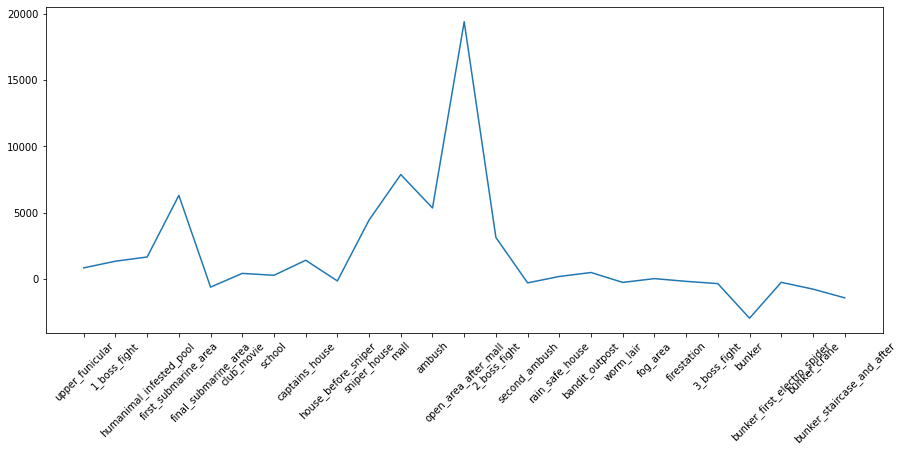

In [18]:
sum_list = []
for p in list(pos['player'].unique()):
    t = pos[pos['player']==p][['server_timestamp', 'area']]
    t['delta'] = (t['server_timestamp']-t['server_timestamp'].shift(1)).dt.seconds
    #For each player I calculate deltas between records 
    #and then subtract the mean delta without outliers
    delta_cut = t['delta'][t['delta']<t['delta'].mean()+3*t['delta'].std()]
    t['delta'] = t['delta'] - delta_cut.mean()
    sum_list.append(t)
    
#That's some rough assumption, players are supposed to progress at somewhat same speed 
#But that's actually the thing we wanted to check
sum_df = pd.concat(sum_list).dropna()  
sum_df = sum_df.sort_values(by='server_timestamp')
sum_df['delta'] = sum_df['delta'].rolling(pos['player'].nunique()).mean()
sum_df['time_from_start'] = (sum_df['server_timestamp'] - sum_df['server_timestamp'].min()).dt.seconds

to_plot = sum_df.groupby('area').agg({'delta': 'sum', 'time_from_start': 'min'})\
            .reset_index(drop=False)
to_plot.columns = ['area', 'delta', 'time_from_start']                                  
to_plot = to_plot.sort_values(by='time_from_start') 

plt.rcParams["figure.figsize"] = (15,6)
plt.plot(to_plot['area'], to_plot['delta'])
plt.xticks(rotation=45)
plt.show()

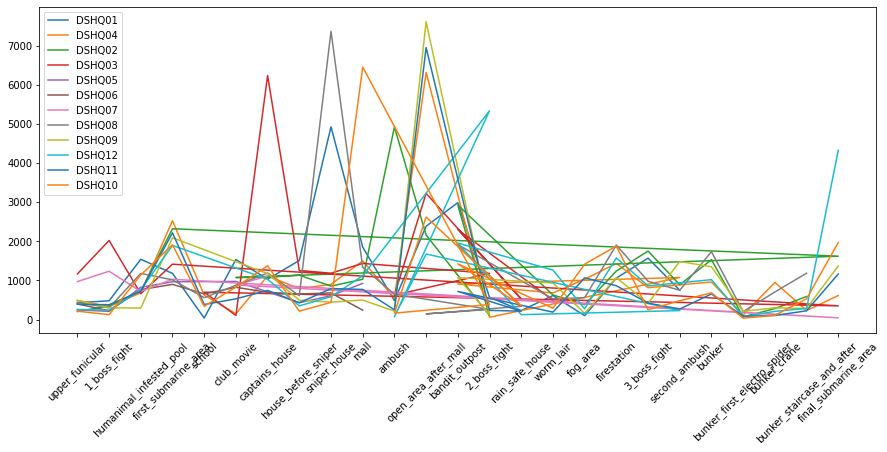

In [19]:
sum_list = []
for p in list(pos['player'].unique()):
    t = pos[pos['player']==p][['server_timestamp', 'area']]
    t['delta'] = (t['server_timestamp']-t['server_timestamp'].shift(1)).dt.seconds
    to_plot = t.groupby('area').agg({'delta': 'sum', 'server_timestamp': 'min'})\
            .reset_index(drop=False)
    to_plot.columns = ['area', 'delta', 'server_timestamp']                                  
    to_plot = to_plot.sort_values(by='server_timestamp') 
    plt.plot(to_plot['area'], to_plot['delta'], label=p)
    
plt.rcParams["figure.figsize"] = (20,5)
plt.legend()
plt.xticks(rotation=45)
plt.show()


This plot is a mess. That's because every player had a bit different route. (For example, we can see that some players had reached the final area very early in a game). But I'm not using this plot to discover player's path, but to see if our target locations are affected by time gaps. And they are not.

Only player DSHQ12 fought 2nd boss during this brake.

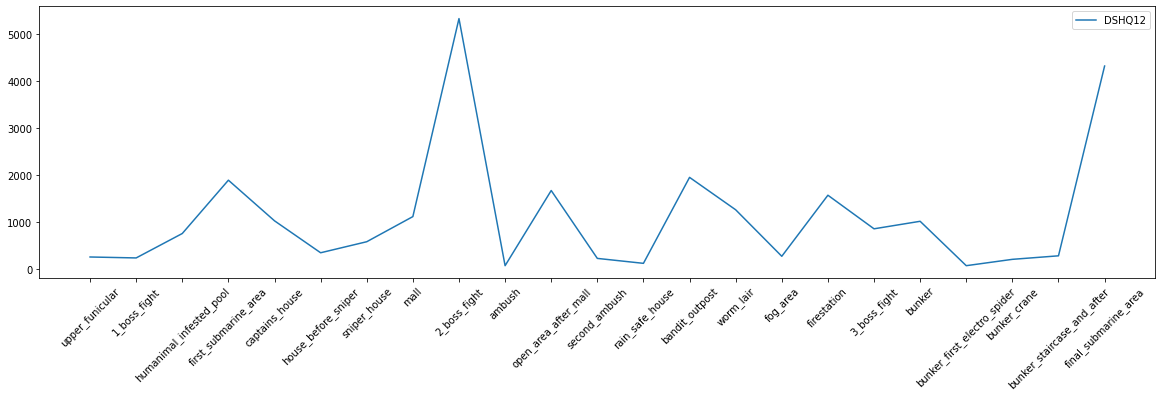

In [20]:
p = 'DSHQ12'
t = pos[pos['player']==p][['server_timestamp', 'area']]
t['delta'] = (t['server_timestamp']-t['server_timestamp'].shift(1)).dt.seconds
to_plot = t.groupby('area').agg({'delta': 'sum', 'server_timestamp': 'min'})\
        .reset_index(drop=False)
to_plot.columns = ['area', 'delta', 'server_timestamp']                                  
to_plot = to_plot.sort_values(by='server_timestamp') 

plt.rcParams["figure.figsize"] = (20,5)
plt.plot(to_plot['area'], to_plot['delta'], label=p)
    

plt.legend()
plt.xticks(rotation=45)
plt.show()


We will remove this record from analysis.

In [21]:
#And just to know - let's remove some big gaps and calculate ,ean period of position update
for p in list(pos['player'].unique()):
    t = pos[pos['player']==p].sort_values(
        by='server_timestamp')[['server_timestamp']]
    delta = (t['server_timestamp']-t['server_timestamp'].shift(1)).dt.seconds
    delta = delta[delta<delta.mean()+3*delta.std()]
    print(p, delta.mean())

DSHQ01 14.066533599467732
DSHQ04 13.513870541611626
DSHQ02 13.286045165026056
DSHQ03 16.69129720853859
DSHQ05 12.838874680306905
DSHQ06 12.224880382775119
DSHQ07 13.105670103092784
DSHQ08 12.87014640356461
DSHQ09 12.730600292825768
DSHQ12 13.70946393117141
DSHQ11 13.77152899824253
DSHQ10 13.93792172739541


#### Deaths

In [22]:
print(deaths.columns)

Index(['player', 'user_id', 'session_data.user_id', 'id', 'event_type',
       'timestamp', 'server_timestamp', 'session_id', 'protocol_version',
       'session_event_seq_num', 'country_code_iso', 'client_timezone',
       'event_data.weapon_type', 'event_data.cause', 'event_data.enemy_type',
       'event_data.killed_by', 'pos_z', 'pos_x', 'pos_y',
       'session_data.game_id', 'session_data.platform_id', 'session_data.sec',
       'session_data.build_id', 'session_data.playtest_id',
       'session_data.playtest_player',
       'session_data.input_device.input_device',
       'session_data.level_state.map_name',
       'session_data.difficulty.difficulty', 'debugevent.timestamp',
       'debugevent.millhost', 'debugevent.flowhost', 'debugevent.inflighttime',
       'debugevent.redeliverd', 'debugevent.sequence', 'debugevent.eventcount',
       'debugevent.timeinbuffer', 'debugevent.batchid', 'date', 'area'],
      dtype='object')


In [23]:
death_info_columns = [col for col in deaths.columns if 'event_data' in col]

In [25]:
for col in death_info_columns:
    print('---', col)
    display(deaths[col].value_counts())

--- event_data.weapon_type


no weapons               205
WEAPON_AK_74              37
WEAPON_DYNAMITE           15
WEAPON_VENTIL             14
WEAPON_ASHOT               8
WEAPON_FLAME_DYNAMITE      7
WEAPON_ASHOT_2B            1
WEAPON_UBLUDOK             1
Name: event_data.weapon_type, dtype: int64

--- event_data.cause


wound            67
fire_wound       61
shock            56
radiation        55
collision        18
burn             16
explosion        11
spider_sputum     4
Name: event_data.cause, dtype: int64

--- event_data.enemy_type


PLAYER    288
Name: event_data.enemy_type, dtype: int64

--- event_data.killed_by


died because of scripts    145
NPC_FX                      73
ARAHIND                     44
PLAYER                       8
WEAPON_DYNAMITE              4
WATCHMAN                     4
HARPY                        4
LURKER                       4
HUMANIMAL                    2
Name: event_data.killed_by, dtype: int64

In [26]:
deaths[deaths['event_data.weapon_type']=='no weapons'][
    ['event_data.cause', 'event_data.killed_by']]\
    .value_counts().reset_index().sort_values(
    by=['event_data.cause', 'event_data.killed_by'])

,event_data.cause,event_data.killed_by,0
4,burn,died because of scripts,9
3,collision,died because of scripts,18
1,radiation,died because of scripts,55
2,shock,ARAHIND,40
9,shock,HUMANIMAL,2
6,shock,LURKER,4
5,shock,NPC_FX,6
7,shock,WATCHMAN,4
8,wound,HARPY,4
0,wound,died because of scripts,63


There was a question about the first boss area if we could distinguish falling willingly from being pushed by an enemy. I don't see a straightforward way to see it from the types and sources of death. But at least we can make an assumption that if a player didn't make a single shot, he misjudged the situation and jumped himself.

#### Shots

In [27]:
print(shots.columns)

Index(['player', 'user_id', 'session_data.user_id', 'id', 'event_type',
       'timestamp', 'server_timestamp', 'session_id', 'protocol_version',
       'session_event_seq_num', 'country_code_iso', 'client_timezone',
       'event_data.ammo_type', 'event_data.weapon_type',
       'event_data.ammo_left', 'event_data.total_ammo_left',
       'session_data.game_id', 'session_data.platform_id', 'session_data.sec',
       'session_data.build_id', 'session_data.playtest_id',
       'session_data.playtest_player',
       'session_data.input_device.input_device',
       'session_data.level_state.map_name',
       'session_data.difficulty.difficulty', 'debugevent.timestamp',
       'debugevent.millhost', 'debugevent.flowhost', 'debugevent.inflighttime',
       'debugevent.redeliverd', 'debugevent.sequence', 'debugevent.eventcount',
       'debugevent.timeinbuffer', 'debugevent.batchid', 'date'],
      dtype='object')


In [28]:
shots_info_columns = [col for col in shots.columns if 'event_data' in col]

In [29]:
shots[shots_info_columns]

,event_data.ammo_type,event_data.weapon_type,event_data.ammo_left,event_data.total_ammo_left
0,ammo_545x39_fmj,WEAPON_AK_74,73,87
1,ammo_545x39_fmj,WEAPON_AK_74,75,89
2,ammo_545x39_fmj,WEAPON_AK_74,72,86
3,ammo_545x39_fmj,WEAPON_AK_74,74,88
4,ammo_545x39_fmj,WEAPON_AK_74,72,86
...,...,...,...,...
20925,ammo_545x39_fmj,WEAPON_AK_SAMMY,49,133
20926,ammo_545x39_fmj,WEAPON_AK_SAMMY,50,134
20927,ammo_545x39_fmj,WEAPON_AK_SAMMY,52,136
20928,ammo_545x39_fmj,WEAPON_AK_SAMMY,43,127


### Players struggle in the third batwing encounter

Now, to the mentioned issues.

"Players struggle in the third batwing encounter"
As can be seen fron the report, it's a final boss location, "final_boss_fight".

Some theories:
1) How many deaths are there for every player in this location?
2) Are they indeed so numerours in comparison to other bosses?
3) How fast do players die in this location, how much damage do they get, how big is dps?
4) How much ammo and heals do players have (if I can find this out) at the start of this location (also in comparison)

In [30]:
# How many deaths are there for every player in this location?

deaths[deaths['area'].isin(['1_boss_fight', '2_boss_fight', '3_boss_fight'])]\
    .groupby(['player', 'area'])['id'].nunique()

player  area        
DSHQ01  1_boss_fight     1
        3_boss_fight     5
DSHQ02  1_boss_fight     2
        2_boss_fight     1
        3_boss_fight     7
DSHQ03  1_boss_fight    16
        2_boss_fight     4
DSHQ04  1_boss_fight     2
        3_boss_fight     1
DSHQ06  1_boss_fight     1
DSHQ07  1_boss_fight    13
DSHQ08  1_boss_fight     1
        3_boss_fight     4
DSHQ09  1_boss_fight     2
        2_boss_fight     1
DSHQ11  1_boss_fight     2
        3_boss_fight     1
DSHQ12  2_boss_fight     2
        3_boss_fight     2
Name: id, dtype: int64

There is some hint of high deathrate at this location, but there are several things to be done before we could say anything: <br>
1) Put 0 if player cleared this boss without a single death (has a position after this area and doesn't have a death record)
2) Decide how to treat numerous deaths at the first boss fight.


In [31]:
deaths_count = deaths[deaths['area'].isin(['1_boss_fight', '2_boss_fight', '3_boss_fight'])]\
    .groupby(['player', 'area'])['id'].nunique().reset_index()

In [32]:
#I didn't find any issues with this method - if player survives a boss, 
#he proceeds to the next area and has further positions,
#so I check for any further movements

for area in ['1_boss_fight', '2_boss_fight', '3_boss_fight']:
    for p in list(pos['player'].unique()):
        if (not area in deaths_count[deaths_count['player']==p]['area'].to_list()) and\
            (area in pos[pos['player']==p]['area'].drop_duplicates().to_list()):
            max_time = pos[pos['area']==area]['server_timestamp'].max()
            after_last_boss = pos[pos['server_timestamp']>max_time]
            if len(after_last_boss)>0:
                deaths_count = pd.concat([deaths_count, \
                    pd.DataFrame.from_dict({'player': [p], 'area': [area], 'id': [0]})])


In [33]:
deaths_count.sort_values(by=['player', 'area']).set_index(['player', 'area'])

id
player area            
DSHQ01 1_boss_fight   1
       2_boss_fight   0
       3_boss_fight   5
DSHQ02 1_boss_fight   2
       2_boss_fight   1
       3_boss_fight   7
DSHQ03 1_boss_fight  16
       2_boss_fight   4
DSHQ04 1_boss_fight   2
       2_boss_fight   0
       3_boss_fight   1
DSHQ05 1_boss_fight   0
DSHQ06 1_boss_fight   1
DSHQ07 1_boss_fight  13
DSHQ08 1_boss_fight   1
       2_boss_fight   0
       3_boss_fight   4
DSHQ09 1_boss_fight   2
       2_boss_fight   1
       3_boss_fight   0
DSHQ10 1_boss_fight   0
       2_boss_fight   0
       3_boss_fight   0
DSHQ11 1_boss_fight   2
       2_boss_fight   0
       3_boss_fight   1
DSHQ12 1_boss_fight   0
       2_boss_fight   2
       3_boss_fight   2

Let's count mean number of deaths for players who managed to beat the third boss.

In [34]:
deaths_count[deaths_count['player']\
            .isin(deaths_count[deaths_count['area']=='3_boss_fight']['player'].to_list())]\
            .groupby('area')['id'].mean()

area
1_boss_fight    1.25
2_boss_fight    0.50
3_boss_fight    2.50
Name: id, dtype: float64

We can see, that on the third time the number of deaths even bigger than on the first time, despite the problems with first boss location.

There are some options to filter out those quick deaths from falling, for example, check time spent for every try and filter out all the quick deaths. But that needs some discussion and may be solved easier with some other data (for example, with logs of damage taken)

But deaths are not the only measure of struggling.

Let's calculate some statistics about boss fights.
- Total time spent
- Number of deaths
- Time one try
- Number of shots made
- Total ammo at the start of the fight
- Total ammo at the finish of the fight (before death or before winning?)

There are two ways to calculate time spent in location. <br>
1) From first log in area N to the first log in area N+1. 
2) And from first log in area N to the last log in area N. <br>

The first way may have problems with pauses in playing, cutscenes, and the second with short stays.
Remembering the fact that there are some gaps in logs and that we are trying to check if the fight was too long (while mean delta between logs is 15 seconds), we'd better stick to the second variant.

In [35]:
#I want to unite positions and deaths to be able to distinguish two boss attempts.

col_list = ['player', 'server_timestamp', 'event_type', 'area']
events = pd.concat([pos[col_list], deaths[col_list]])

events['area_state'] = events['area'] + '_' + events['event_type']

events['server_timestamp'] = pd.to_datetime(events['server_timestamp'])
events = events.sort_values(by=['player', 'server_timestamp']).reset_index(drop=True)

In [36]:
events.head()

,player,server_timestamp,event_type,area,area_state
0,DSHQ01,2019-10-09 08:19:57,position,upper_funicular,upper_funicular_position
1,DSHQ01,2019-10-09 08:20:07,position,upper_funicular,upper_funicular_position
2,DSHQ01,2019-10-09 08:20:17,position,upper_funicular,upper_funicular_position
3,DSHQ01,2019-10-09 08:20:32,position,upper_funicular,upper_funicular_position
4,DSHQ01,2019-10-09 08:20:42,position,upper_funicular,upper_funicular_position


In [37]:
player_paths = []

for p in list(events['player'].unique()):
    #Looking for the first record in location
    df_first = events[events['player']==p]
    df_first['first_pos'] = (df_first['area_state']!=df_first['area_state'].shift(1)).astype(int)  
    df_first.iloc[0]['first_pos'] = 1
    df_first = df_first[df_first['first_pos']==1]
    
    #Looking for the lasr record in location
    df_last = events[events['player']==p]
    df_last['last_pos'] = (df_last['area_state']!=df_last['area_state'].shift(-1)).astype(int)  
    df_last.iloc[-1]['last_pos'] = 1
    df_last = df_last[df_last['last_pos']==1]
    
    df_first = df_first[['server_timestamp', 'area']]\
        .rename(columns={'server_timestamp': 'start_time'}).reset_index(drop=True)
    df_last = df_last[['server_timestamp']]\
        .rename(columns={'server_timestamp': 'finish_time'}).reset_index(drop=True)
    
    df = df_first.join(df_last)
    df['delta'] = (df['finish_time'] - df['start_time']).dt.seconds
    df['player'] = p
    df = df[['player', 'area', 'start_time', 'finish_time', 'delta']]
    player_paths.append(df)

player_paths = pd.concat(player_paths, ignore_index=True, axis=0)  
#it seems, that there are two simultanious records - about death and about position
player_paths = player_paths[player_paths['delta']>0] 

In [38]:
players_3boss = list(player_paths[player_paths['area']=='3_boss_fight']['player'].unique())

In [39]:
def sum_time(x, area_name):
    return x[x['area']==area_name]['delta'].sum()

print('Total time in the area:')

for area in ['1_boss_fight', '2_boss_fight', '3_boss_fight']:
    print(area, player_paths[player_paths['player'].isin(players_3boss)].groupby('player')\
          .apply(lambda x: sum_time(x, area)).mean().round(0))

Total time in the area:
1_boss_fight 282.0
2_boss_fight 836.0
3_boss_fight 658.0


In [40]:
def mean_time(x, area_name):
    return x[x['area']==area_name]['delta'].mean()

print('Time per an attempt:')

for area in ['1_boss_fight', '2_boss_fight', '3_boss_fight']:
    print(area, player_paths[player_paths['player'].isin(players_3boss)].groupby('player')\
          .apply(lambda x: mean_time(x, area)).mean().round(0))

Time per an attempt:
1_boss_fight 135.0
2_boss_fight 301.0
3_boss_fight 226.0


Hmm, I guess, something's off. Let's have a closer look at all boss attempts.

1_boss_fight


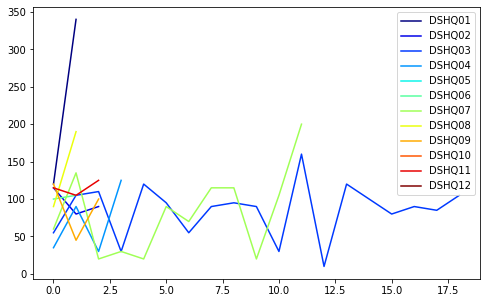

2_boss_fight


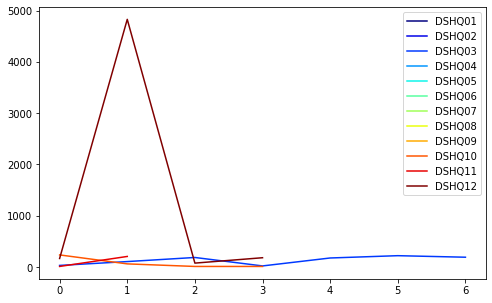

3_boss_fight


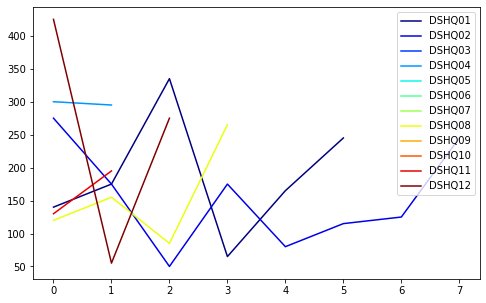

In [41]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.jet(np.linspace(0,1,12)))
for area in ['1_boss_fight', '2_boss_fight', '3_boss_fight']:
    print(area)
    for p in list(player_paths['player'].unique()):
        plt.plot(player_paths[(player_paths['player']==p) & (player_paths['area']==area)]['delta']\
            .reset_index(drop=True), label=p)
    plt.legend()
    plt.show()

Look, here he is, player DSHQ12! 

In [42]:
player_paths[(player_paths['player']=='DSHQ12') \
             & (player_paths['area']=='2_boss_fight') \
             & (player_paths['delta']> 3000)]

,player,area,start_time,finish_time,delta
1814,DSHQ12,2_boss_fight,2019-10-11 10:13:26,2019-10-11 11:33:56,4830


In [43]:
player_paths = player_paths[~((player_paths['player']=='DSHQ12') \
             & (player_paths['area']=='2_boss_fight') \
             & (player_paths['delta']> 3000))]
player_paths = player_paths.reset_index(drop=True)

1_boss_fight


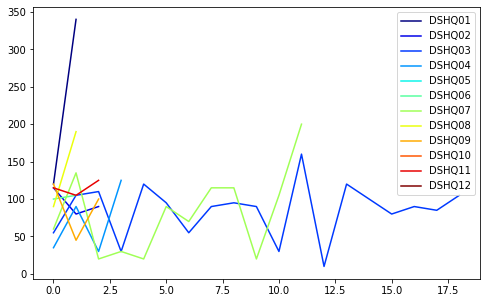

2_boss_fight


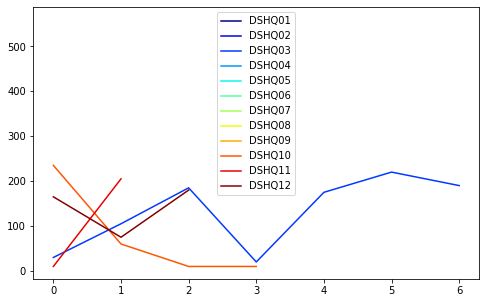

3_boss_fight


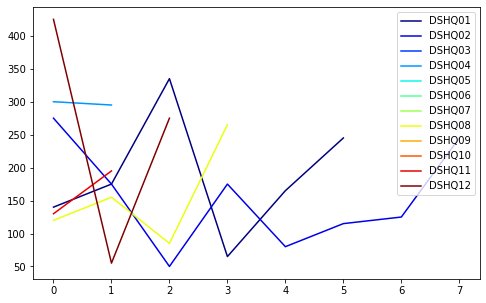

In [44]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.jet(np.linspace(0,1,12)))
for area in ['1_boss_fight', '2_boss_fight', '3_boss_fight']:
    print(area)
    for p in list(player_paths['player'].unique()):
        plt.plot(player_paths[(player_paths['player']==p) & (player_paths['area']==area)]['delta']\
            .reset_index(drop=True), label=p)
    plt.legend()
    plt.show()

And now we can check again

In [45]:
def sum_time(x, area_name):
    return x[x['area']==area_name]['delta'].sum()

for area in ['1_boss_fight', '2_boss_fight', '3_boss_fight']:
    print(area, player_paths[player_paths['player'].isin(players_3boss)].groupby('player')\
          .apply(lambda x: sum_time(x, area)).mean().round(0))

1_boss_fight 282.0
2_boss_fight 232.0
3_boss_fight 658.0


In [46]:
def mean_time(x, area_name):
    return x[x['area']==area_name]['delta'].mean()

for area in ['1_boss_fight', '2_boss_fight', '3_boss_fight']:
    print(area, player_paths[player_paths['player'].isin(players_3boss)].groupby('player')\
          .apply(lambda x: mean_time(x, area)).mean().round(0))

1_boss_fight 135.0
2_boss_fight 155.0
3_boss_fight 226.0


Now we are talking!!

That's already some meaninful result, but we'd better check shots either.
There'no position in "shots" table. So we must join it by timestamp.

In [47]:
#Positions
sqlcode = '''
select shots.*, pp.area
from shots
join player_paths as pp 
    on shots.player=pp.player
    and (shots.server_timestamp between pp.start_time and pp.finish_time) 
'''

shots = ps.sqldf(sqlcode,locals())

In [48]:
shots_count = shots[shots['area'].isin(['1_boss_fight', '2_boss_fight', '3_boss_fight'])]\
    .groupby(['player', 'area'])['id'].nunique()
shots_count = shots_count.to_frame()

In [49]:
deaths_shots_count = pd.concat([deaths_count.set_index(['player', 'area']), shots_count], axis=1)
deaths_shots_count.columns = ['deaths', 'shots']

In [50]:
deaths_shots_count = deaths_shots_count.sort_index().fillna(0)

In [51]:
shots['event_data.total_ammo_left'] = shots['event_data.total_ammo_left']\
    .replace({'no_items': '0'}).astype(int)

In [52]:
def total_starting_ammo(x, col):
    start = x['server_timestamp'].min()
    return x[x['server_timestamp']==start][col].min()

In [53]:
starting_ammo = shots[shots['area'].isin(['1_boss_fight', '2_boss_fight', '3_boss_fight'])]\
    .groupby(['player', 'area'])[['server_timestamp', 'event_data.total_ammo_left']]\
    .apply(lambda x: total_starting_ammo(x, 'event_data.total_ammo_left'))
starting_ammo = starting_ammo.to_frame()
starting_ammo.columns = ['starting_ammo']

In [54]:
boss_time = player_paths[(player_paths['area']\
            .isin(['1_boss_fight', '2_boss_fight', '3_boss_fight'])) \
                & (player_paths['player'].isin(players_3boss))]\
            .groupby(['player', 'area']).agg({'delta': ['mean', 'sum']}).round(0)
boss_time.columns = ['boss_mean_time', 'boss_sum_time']

In [55]:
bosses_count = pd.concat([deaths_shots_count, starting_ammo, boss_time], axis=1)
bosses_count = bosses_count.sort_index()

In [56]:
bosses_count

deaths   shots  starting_ammo  boss_mean_time  \
player area                                                          
DSHQ01 1_boss_fight       1    18.0           13.0           230.0   
       2_boss_fight       0   115.0           78.0           560.0   
       3_boss_fight       5   388.0           80.0           188.0   
DSHQ02 1_boss_fight       2    27.0           13.0            95.0   
       2_boss_fight       1     2.0           88.0            95.0   
       3_boss_fight       7   270.0           83.0           155.0   
DSHQ03 1_boss_fight      16  1155.0           70.0             NaN   
       2_boss_fight       4   159.0           20.0             NaN   
DSHQ04 1_boss_fight       2   107.0           82.0            70.0   
       2_boss_fight       0     0.0            NaN            40.0   
       3_boss_fight       1   254.0            6.0           298.0   
DSHQ05 1_boss_fight       0    56.0           86.0             NaN   
DSHQ06 1_boss_fight       1   191.0           85.0             NaN   
DSHQ07 1_boss_fight      13   258.0           13.0             NaN   
DSHQ08 1_boss_fight       1   128.0           78.0           140.0   
       2_boss_fight       0     0.0            NaN           130.0   
       3_boss_fight       4   506.0          136.0           156.0   
DSHQ09 1_boss_fight       2    92.0           84.0            88.0   
       2_boss_fight       1    10.0           49.0            85.0   
       3_boss_fight       0   121.0           82.0           375.0   
DSHQ10 1_boss_fight       0    91.0           86.0           115.0   
       2_boss_fight       0   104.0           41.0            79.0   
       3_boss_fight       0   159.0          145.0           220.0   
DSHQ11 1_boss_fight       2    73.0           89.0           115.0   
       2_boss_fight       0    29.0           84.0           108.0   
       3_boss_fight       1   155.0          135.0           162.0   
DSHQ12 1_boss_fight       0    38.0           83.0           230.0   
       2_boss_fight       2   159.0           88.0           140.0   
       3_boss_fight       2   167.0           78.0           252.0   

                     boss_sum_time  
player area                         
DSHQ01 1_boss_fight          460.0  
       2_boss_fight          560.0  
       3_boss_fight         1125.0  
DSHQ02 1_boss_fight          285.0  
       2_boss_fight           95.0  
       3_boss_fight         1240.0  
DSHQ03 1_boss_fight            NaN  
       2_boss_fight            NaN  
DSHQ04 1_boss_fight          280.0  
       2_boss_fight           40.0  
       3_boss_fight          595.0  
DSHQ05 1_boss_fight            NaN  
DSHQ06 1_boss_fight            NaN  
DSHQ07 1_boss_fight            NaN  
DSHQ08 1_boss_fight          280.0  
       2_boss_fight          130.0  
       3_boss_fight          625.0  
DSHQ09 1_boss_fight          265.0  
       2_boss_fight           85.0  
       3_boss_fight          375.0  
DSHQ10 1_boss_fight          115.0  
       2_boss_fight          315.0  
       3_boss_fight          220.0  
DSHQ11 1_boss_fight          345.0  
       2_boss_fight          215.0  
       3_boss_fight          325.0  
DSHQ12 1_boss_fight          230.0  
       2_boss_fight          420.0  
       3_boss_fight          755.0

In [57]:
display(bosses_count.loc[players_3boss].reset_index().groupby('area').mean().round(1))

,deaths,shots,starting_ammo,boss_mean_time,boss_sum_time
area,,,,,
1_boss_fight,1.2,71.8,66.0,135.4,282.5
2_boss_fight,0.5,52.4,71.3,154.6,232.5
3_boss_fight,2.5,252.5,93.1,225.8,657.5


In [58]:
bosses_result_table = bosses_count.loc[players_3boss].reset_index().groupby('area').mean().round(1)

Let's compare these numbers.

In [59]:
bosses_result_table.iloc[2, :]/bosses_result_table.iloc[0:1, :].mean()

deaths            2.083333
shots             3.516713
starting_ammo     1.410606
boss_mean_time    1.667651
boss_sum_time     2.327434
dtype: float64

And 3rd boss is way harder than the previous one. There should be some growth of challenge through the game, but I suppose it should be smoother.

we don't know anything about HP and damage done.

### Players struggle in the bunker because they don’t use the fire ammo

Here I tried to find out what is fire ammo using the hint about 4th player, but I'm not sure that ammo_545x39_fmj  is fire, I didn't find anything of the type on the Internet and it's not obvioys from the naming and percentage of usinf in other locations. 

In [62]:
shots[(shots['area']=='bunker') & (shots['player']=='DSHQ04')][
    ['event_data.ammo_type', 'event_data.weapon_type']].value_counts()

event_data.ammo_type  event_data.weapon_type
ammo_545x39_fmj       WEAPON_AK_SAMMY           112
ammo_762x39_fmj       WEAPON_VENTIL               9
ammo_762x39_mg        WEAPON_AK_SAMMY             2
dtype: int64

In [63]:
shots[(shots['area']=='bunker') & (shots['player']=='DSHQ04')].sort_values(by='server_timestamp')[
    ['server_timestamp', 'event_data.ammo_type', 'event_data.weapon_type']]

,server_timestamp,event_data.ammo_type,event_data.weapon_type
4212,2019-10-09 14:11:06.000000,ammo_545x39_fmj,WEAPON_AK_SAMMY
4217,2019-10-09 14:11:06.000000,ammo_545x39_fmj,WEAPON_AK_SAMMY
4218,2019-10-09 14:11:06.000000,ammo_545x39_fmj,WEAPON_AK_SAMMY
4219,2019-10-09 14:11:06.000000,ammo_545x39_fmj,WEAPON_AK_SAMMY
4221,2019-10-09 14:11:06.000000,ammo_545x39_fmj,WEAPON_AK_SAMMY
...,...,...,...
4459,2019-10-09 14:20:36.000000,ammo_545x39_fmj,WEAPON_AK_SAMMY
4458,2019-10-09 14:20:36.000000,ammo_545x39_fmj,WEAPON_AK_SAMMY
4470,2019-10-09 14:20:36.000000,ammo_545x39_fmj,WEAPON_AK_SAMMY
4687,2019-10-09 14:41:46.000000,ammo_762x39_mg,WEAPON_AK_SAMMY


So let's just investigate death rate.

<AxesSubplot:ylabel='area'>

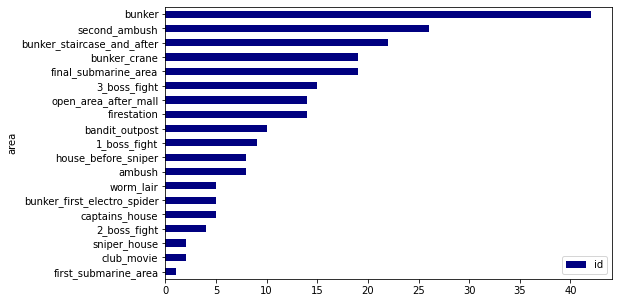

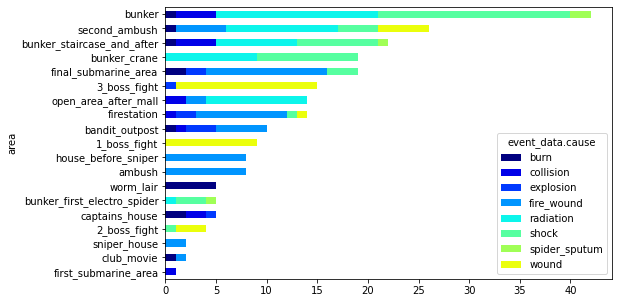

In [64]:
bunker_areas = [area for area in deaths['area'] if 'bunker' in area]
bunker_players = list(pos[pos['area'].isin(bunker_areas)]['player'].unique())

deaths[deaths['player'].isin(bunker_players)]\
    .groupby('area')['id'].count().sort_values(ascending=True).to_frame().plot.barh()

causes = deaths[deaths['player'].isin(bunker_players)]\
    .groupby('area')['event_data.cause'].value_counts().to_frame().unstack().fillna(0)
causes.columns = causes.columns.get_level_values(1)

causes['sum'] = causes.sum(axis=1)
causes = causes.sort_values(by='sum').drop(columns='sum')

causes.plot.barh(stacked=True)

<AxesSubplot:ylabel='area'>

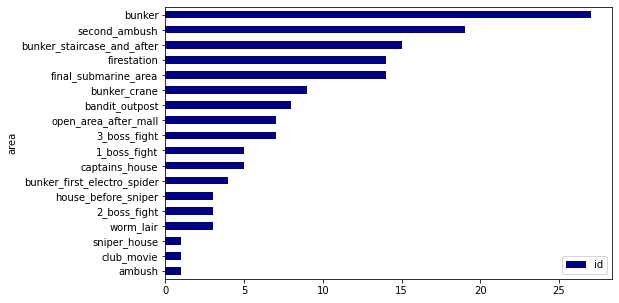

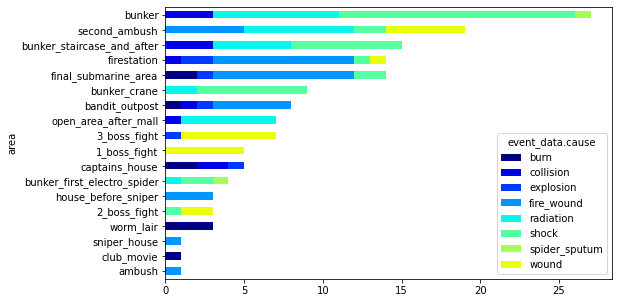

In [65]:
excluded_players = ['DSHQ02', 'DSHQ04']
bunker_areas = [area for area in deaths['area'] if 'bunker' in area]
bunker_players = list(pos[pos['area'].isin(bunker_areas)]['player'].unique())
bunker_players = [p for p in bunker_players if p not in excluded_players]

deaths[deaths['player'].isin(bunker_players)]\
    .groupby('area')['id'].count().sort_values(ascending=True).to_frame().plot.barh()

causes = deaths[deaths['player'].isin(bunker_players)]\
    .groupby('area')['event_data.cause'].value_counts().to_frame().unstack().fillna(0)
causes.columns = causes.columns.get_level_values(1)

causes['sum'] = causes.sum(axis=1)
causes = causes.sort_values(by='sum').drop(columns='sum')

causes.plot.barh(stacked=True)

In the bunker location there are definately muuch more deaths for the players who got there at all.

I've also made some research on ammo type and number of ammo left, but further investigation requires a dicussion and deeper understanding of mechanics.